# Modeling

Development of a range of predictive models to predict NYC restaurant inspection scores
using linear modeling methods.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import distance
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from pandas.tools.plotting import table
from statsmodels.api import OLS
from statsmodels.discrete.discrete_model import MNLogit
from scipy import stats
from tqdm import tqdm

from IPython.display import display, HTML

pd.options.mode.chained_assignment = None
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

sns.set_context("talk")
sns.set_style("white")

%matplotlib inline

In [2]:
# Paths
PATH_YELP_DATA = '../data/yelp_data.csv'
PATH_INSPECTIONS = '../data/nyc_restaurant_inspection_data.csv'
PATH_DEMOGRAPHICS = '../data/demographics_zipcode.csv'

# Global params
nsims = 500

# Import data
data = pd.read_csv('../data/model_data.csv')

# Subset data (inspection year)
data = data.loc[data['inspection_year'] == 2016, :]

# Response transformations
data['sqrt_score'] = np.sqrt(data['score'])

# Predictor transformations
data['sqrt_score_avg'] = np.sqrt(data['score_avg'])
data['sqrt_score_prev'] = np.sqrt(data['score_prev'])
data['log_review_count'] = np.log(data['review_count'])

## Data investigation

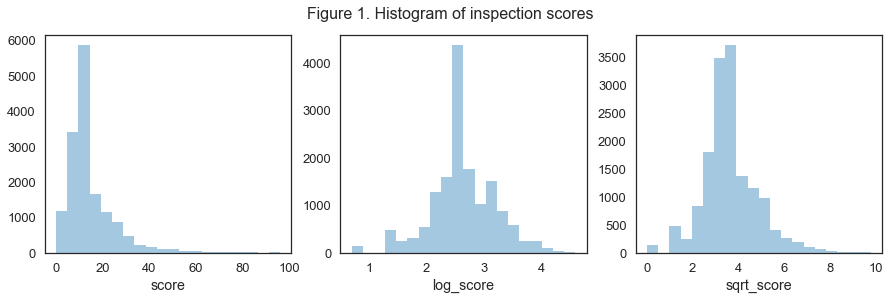

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.ravel()

response_vars =['score', 'log_score', 'sqrt_score']
for c in response_vars:
    i = response_vars.index(c)
    sns.distplot(data[c], bins=20, kde=False, ax=ax[i]);

plt.suptitle("Figure 1. Histogram of inspection scores", fontsize=16)
plt.savefig("output/response_distribution.png", bbox_inches='tight')

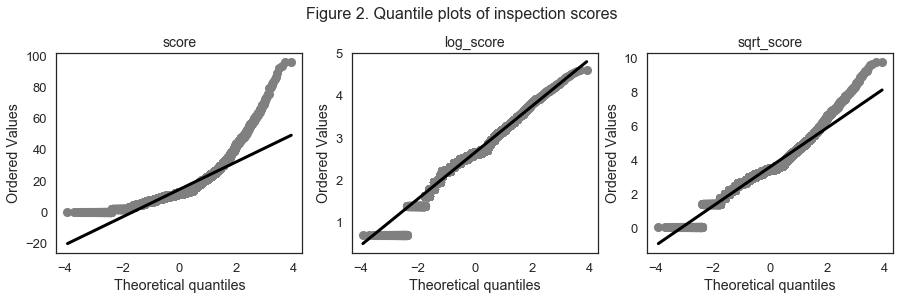

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.ravel()

response_vars =['score', 'log_score', 'sqrt_score']
for c in response_vars:
    i = response_vars.index(c)
    stats.probplot(data[c], plot=ax[i]);
    ax[i].get_lines()[0].set_markerfacecolor('grey')
    ax[i].get_lines()[1].set_color('black')
    ax[i].get_lines()[1].set_linewidth(3)
    ax[i].set_title(c, fontsize=14);
    
plt.suptitle("Figure 2. Quantile plots of inspection scores", fontsize=16);
plt.subplots_adjust(top=0.82);
plt.show()

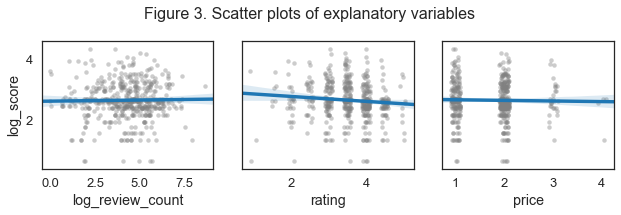

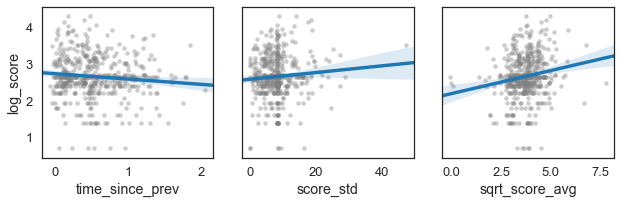

In [5]:
# Yelp ratings and previous inspection scores

df = data.sample(500, random_state=87)
x_vars = ['log_review_count', 'rating', 'price']
g = sns.PairGrid(df, y_vars=["log_score"], x_vars=x_vars[:3], size=3, despine=False)
g.map(sns.regplot, x_jitter=.1, scatter_kws={'s':20,'alpha':0.4, 'color':'grey'});

plt.suptitle("Figure 3. Scatter plots of explanatory variables", fontsize=16);
plt.subplots_adjust(top=0.82);

plt.savefig("output/sqrt_score_scatterplots_yelp.png", bbox_inches='tight')

x_vars = ['time_since_prev', 'score_std', 'sqrt_score_avg']
g = sns.PairGrid(df, y_vars=["log_score"], x_vars=x_vars[:3], size=3, despine=False)
g.map(sns.regplot, x_jitter=.1, scatter_kws={'s':20,'alpha':0.4, 'color':'grey'});

plt.savefig("output/sqrt_score_scatterplots_ratings.png", bbox_inches='tight')

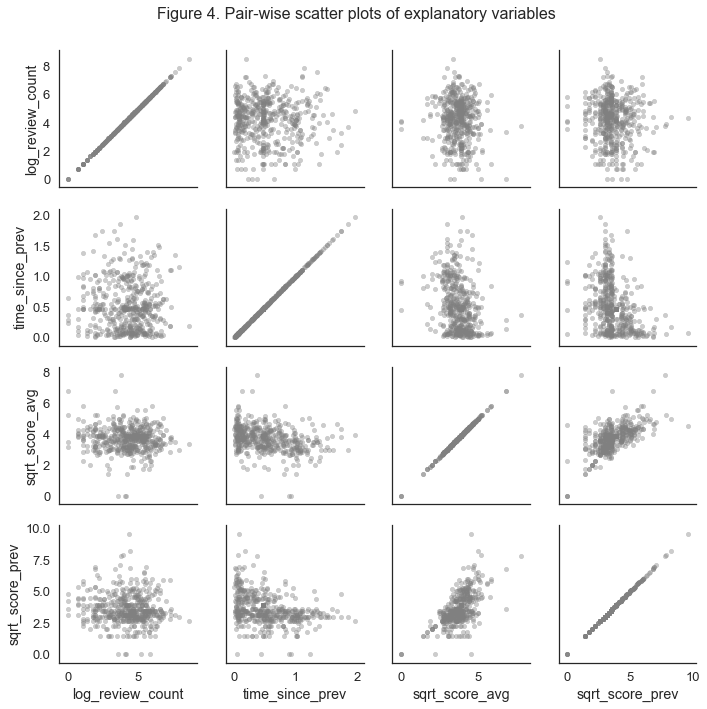

In [6]:
# Scatterplots

x_vars = ['log_review_count', 'time_since_prev', 'sqrt_score_avg', 'sqrt_score_prev']
g = sns.PairGrid(df[x_vars], size=2.5)
g.map(plt.scatter, s=20, alpha=0.4, color='grey');

plt.suptitle("Figure 4. Pair-wise scatter plots of explanatory variables", fontsize=16);
plt.subplots_adjust(top=0.92);

plt.savefig("output/xy_scatterplots.png", bbox_inches='tight')

## Ordinary Least Squares (OLS) Regression

### Yelp review variables

In this section of the report, a number of different linear regression models are evaluated. We start by creating some simple models with a small number of predictors and then systematically expand the number of predictors. For each model the relevant OLS assumptions are reviewed with appropriate interpretation of the model output to answer questions posed in the project statement.

The first model considered includes only three predictors:
* `log_review_count`: Number of Yelp reviews for particular restaurant
* `rating`: Yelp rating for restaurant
* `price`: Price category based on Yelp profile

In [7]:
# Selected predictors + response
model_cols = ['log_review_count', 'rating', 'price', 'log_score']

# Create train and test sets
train_df, test_df = train_test_split(data[model_cols], test_size=0.5, random_state=87)

# Model predictors
X_train = train_df.iloc[:,:-1].values
X_test = test_df.iloc[:,:-1].values

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Response
y_train = train_df.iloc[:,-1].values
y_test = test_df.iloc[:,-1].values

# Fit model
mod = OLS(y_train, X_train)
res = mod.fit()

# Print summary statistics
names = ['const'] + list(train_df.columns[:-1])
display(res.summary(xname=names))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     12.21
Date:                Mon, 16 Jul 2018   Prob (F-statistic):           5.74e-08
Time:                        17:50:29   Log-Likelihood:                -6315.9
No. Observations:                7625   AIC:                         1.264e+04
Df Residuals:                    7621   BIC:                         1.267e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.6500      0.036     73.212      0.000       2.579       2.721
log_review_count     0.0225      0.005      4.982      0.000       0.014       0.031
rating              -0.0356      0.009     -3.827      0.000      -0.054      -0.017
price                0.0085      0.011      0.771      0.441      -0.013       0.030
==============================================================================
Omnibus:                      262.104   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              530.991
Skew:                          -0.240   Prob(JB):                    4.98e-116
Kurtosis:                       4.200   Cond. No.                         35.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on the model output (from the `statsmodels` package in Python) we note that the `log_review_count` and `rating` variables are significant. Given the concerns with the normality of the response we note that the standard errors of the parameter estimates and therefore p-values provided in the output should be interpreted with care. It is also noted that the R-squared of the model is extremely low, suggesting that these predictors are not effective at explaining the variation in the response. However, the F-statistic of the model is large enough to suggest that the overall model is statistically significant.

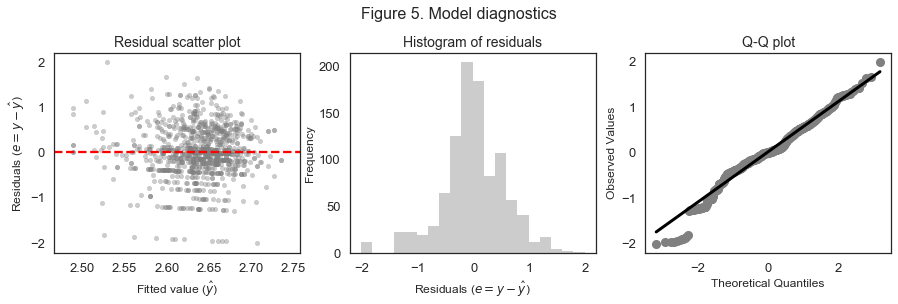

In [8]:
# Calculate errors
pred = res.fittedvalues
errors = y_train - pred

sample = np.random.randint(len(pred), size=1000)
pred = pred[sample]
errors = errors[sample]

# Residual plots
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].scatter(pred, errors, color='grey', alpha=0.4, s=20)
ax[0].axhline(y=0, color='red', label='zero error', linestyle='dashed')
ax[0].set_title('Residual scatter plot', fontsize=14)
ax[0].set_xlabel('Fitted value ($\hat{y}$)', fontsize=12)
ax[0].set_ylabel('Residuals ($e = y - \hat{y}$)', fontsize=12);

ax[1].hist(errors, color='grey', bins=20, alpha=0.4);
ax[1].set_title('Histogram of residuals', fontsize=14)
ax[1].set_xlabel('Residuals ($e = y - \hat{y}$)', fontsize=12)
ax[1].set_ylabel('Frequency', fontsize=12);

stats.probplot(errors, plot=ax[2]);
ax[2].get_lines()[0].set_markerfacecolor('grey')
ax[2].get_lines()[1].set_color('black')
ax[2].get_lines()[1].set_linewidth(3)
ax[2].set_title('Q-Q plot', fontsize=14);
ax[2].set_xlabel('Theoretical Quantiles', fontsize=12)
ax[2].set_ylabel('Observed Values', fontsize=12);

plt.suptitle("Figure 5. Model diagnostics", fontsize=16);
plt.subplots_adjust(top=0.82);

plt.savefig("output/modelA_diagnostics.png", bbox_inches='tight')

### Inspection score variables

The next model considers a number of variables based on the restuarant inspection data:

* `sqrt_score_avg`: Square-root of average historic inspection score for restaurant
* `time_since_prev`: Time (fraction of year) since previous inspection
* `restaurant_name_chain`: Flag indicating if the restaurant is likely part of a chain

In [9]:
# Selected predictors + response
model_cols = ['sqrt_score_avg', 'time_since_prev', 'restaurant_name_chain', 'log_score']

# Create train and test sets
train_df, test_df = train_test_split(data[model_cols], test_size=0.5, random_state=87)

# Model predictors
X_train = train_df.iloc[:,:-1].values
X_test = test_df.iloc[:,:-1].values

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Response
y_train = train_df.iloc[:,-1].values
y_test = test_df.iloc[:,-1].values

# Fit model
mod = OLS(y_train, X_train)
res = mod.fit()

# Print summary statistics
names = ['const'] + list(train_df.columns[:-1])
display(res.summary(xname=names))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     65.45
Date:                Mon, 16 Jul 2018   Prob (F-statistic):           8.86e-42
Time:                        17:50:31   Log-Likelihood:                -6237.2
No. Observations:                7625   AIC:                         1.248e+04
Df Residuals:                    7621   BIC:                         1.251e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.4213      0.035     68.642      0.000       2.352       2.490
sqrt_score_avg            0.0691      0.008      8.364      0.000       0.053       0.085
time_since_prev          -0.0523      0.017     -3.151      0.002      -0.085      -0.020
restaurant_name_chain    -0.1695      0.022     -7.616      0.000      -0.213      -0.126
==============================================================================
Omnibus:                      326.113   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              683.064
Skew:                          -0.293   Prob(JB):                    4.73e-149
Kurtosis:                       4.344   Cond. No.                         23.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model output shows that all three predictors are significant at a 5% significance level. The coefficient estimate for historic inspection scores (`sqrt_score_avg`) suggests that inspection scores are positive correlated with the response. It makes sense that restaurants will likely receive inspection scores similar to what they have received in the past. The time since previous inspection (`time_since_prev`) variable has a negative parameter estimate, meaning that restaurants that have not been inspected for a longer period are likely to receive a lower (better) score. This would make sense if inspectors visit problematic restaurants more frequently. Lastly we note that restaurants that are part of a chain are expected to have lower (better) scores. This could be explained by chains/franchises paying more attention to compliance given potential reputational risk and having access to greater resources. Again we note that the standard errors of the model should be interpreted with caution given the concerns with the model assumptions. The F-statistic of the model (`63.88`) is also significantly larger than for the Yelp variables model (`12.21`). 

The R-squared is higher compared to the model based on the Yelp variables, suggesting that these variables explain more variation in the response. 

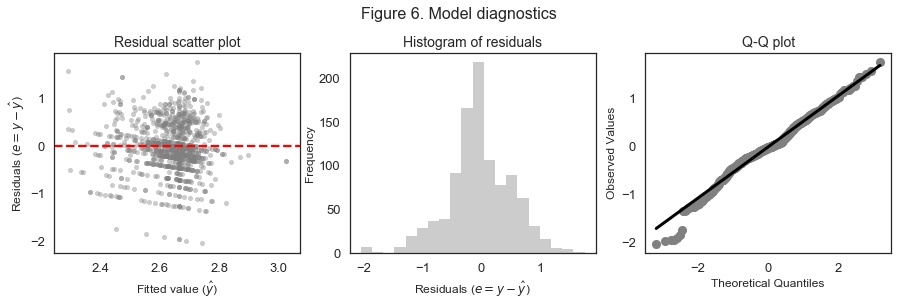

In [10]:
# Calculate errors
pred = res.fittedvalues
errors = y_train - pred

sample = np.random.randint(len(pred), size=1000)
pred = pred[sample]
errors = errors[sample]

# Residual plots
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].scatter(pred, errors, color='grey', alpha=0.4, s=20)
ax[0].axhline(y=0, color='red', label='zero error', linestyle='dashed')
ax[0].set_title('Residual scatter plot', fontsize=14)
ax[0].set_xlabel('Fitted value ($\hat{y}$)', fontsize=12)
ax[0].set_ylabel('Residuals ($e = y - \hat{y}$)', fontsize=12);

ax[1].hist(errors, color='grey', bins=20, alpha=0.4);
ax[1].set_title('Histogram of residuals', fontsize=14)
ax[1].set_xlabel('Residuals ($e = y - \hat{y}$)', fontsize=12)
ax[1].set_ylabel('Frequency', fontsize=12);

stats.probplot(errors, plot=ax[2]);
ax[2].get_lines()[0].set_markerfacecolor('grey')
ax[2].get_lines()[1].set_color('black')
ax[2].get_lines()[1].set_linewidth(3)
ax[2].set_title('Q-Q plot', fontsize=14);
ax[2].set_xlabel('Theoretical Quantiles', fontsize=12)
ax[2].set_ylabel('Observed Values', fontsize=12);

plt.suptitle("Figure 6. Model diagnostics", fontsize=16);
plt.subplots_adjust(top=0.82);

plt.savefig("output/modelB_diagnostics.png", bbox_inches='tight')

The observations from the model diagnostics are largely consistent with the model from the previous section. The residuals are more normally distributed, although we still observe deviations in the tails of the distribution, which is really distorted by the high density in the center of the distribution. 

### Restaurant category variables

The next model includes the category of each restaurant in addition to the Yelp review and inspsection variables considered in the previous sections. We are interested to understand if there is a relationship between restaurant category (e.g. Indian, Mexican, etc.) and inspection score.

In [11]:
# Predictors
model_cols = ['log_review_count', 'rating', 'price', 
              'sqrt_score_avg', 'time_since_prev', 'restaurant_name_chain']

cat_cols = [c for c in data.columns if "cat_" in c]
cat_cols.sort()
for c in cat_cols:
    model_cols.append(c)
        
# Response     
model_cols.append('log_score')

# Create train and test sets
train_df, test_df = train_test_split(data[model_cols], test_size=0.5, random_state=87)

# Model predictors
X_train = train_df.iloc[:,:-1].values
X_test = test_df.iloc[:,:-1].values

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Response
y_train = train_df.iloc[:,-1].values
y_test = test_df.iloc[:,-1].values

# Fit model
mod = OLS(y_train, X_train)
res = mod.fit()

# Print summary statistics
names = ['const'] + list(train_df.columns[:-1])
display(res.summary(xname=names))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     6.446
Date:                Mon, 16 Jul 2018   Prob (F-statistic):           2.25e-43
Time:                        17:50:32   Log-Likelihood:                -6162.8
No. Observations:                7625   AIC:                         1.244e+04
Df Residuals:                    7570   BIC:                         1.282e+04
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.5710      0.060     42.674      0.000       2.453       2.689
log_review_count          0.0133      0.005      2.735      0.006       0.004       0.023
rating                   -0.0585      0.011     -5.574      0.000      -0.079      -0.038
price                     0.0031      0.013      0.245      0.807      -0.022       0.028
sqrt_score_avg            0.0565      0.008      6.773      0.000       0.040       0.073
time_since_prev          -0.0438      0.017     -2.636      0.008      -0.076      -0.011
restaurant_name_chain    -0.2065      0.035     -5.970      0.000      -0.274      -0.139
cat_asianfusion           0.0872      0.048      1.825      0.068      -0.006       0.181
cat_bagels                0.0560      0.052      1.082      0.279      -0.045       0.157
cat_bakeries             -0.0048      0.029     -0.164      0.870      -0.062       0.052
cat_bars                 -0.0117      0.030     -0.387      0.699      -0.071       0.048
cat_bbq                   0.0448      0.060      0.750      0.454      -0.072       0.162
cat_breakfast_brunch     -0.0040      0.026     -0.152      0.879      -0.055       0.047
cat_bubbletea             0.0594      0.060      0.985      0.325      -0.059       0.178
cat_burgers               0.0370      0.031      1.185      0.236      -0.024       0.098
cat_cafes                -0.0184      0.036     -0.504      0.614      -0.090       0.053
cat_caribbean             0.0792      0.053      1.497      0.135      -0.025       0.183
cat_chicken_wings         0.0547      0.046      1.185      0.236      -0.036       0.145
cat_chinese               0.0845      0.030      2.864      0.004       0.027       0.142
cat_cocktailbars         -0.0157      0.040     -0.390      0.697      -0.095       0.063
cat_coffee               -0.0539      0.025     -2.146      0.032      -0.103      -0.005
cat_delis                 0.1315      0.044      3.018      0.003       0.046       0.217
cat_desserts             -0.0634      0.038     -1.686      0.092      -0.137       0.010
cat_diners                0.0311      0.039      0.798      0.425      -0.045       0.108
cat_french                0.0403      0.049      0.820      0.412      -0.056       0.137
cat_greek                -0.0388      0.069     -0.565      0.572      -0.173       0.096
cat_hotdogs              -0.0008      0.040     -0.020      0.984      -0.079       0.077
cat_icecream              0.0515      0.057      0.897      0.370      -0.061       0.164
cat_indpak                0.1385      0.041      3.350      0.001       0.057       0.220
cat_italian               0.0278      0.026      1.076      0.282      -0.023       0.078
cat_japanese              0.0196      0.039      0.496      0.620      -0.058       0.097
cat_juicebars          

Only a small number of the restaurant category indicators appear to be significant at the 5% significance level, which includes Chinese (`cat_chinese`), Deli's (`cat_delis`), Indian/Pakistani cuisine (`cat_indpak`), Latin (`cat_latin`), Mexican (`cat_mexican`) and New American (`cat_newamerican`). All of these categories appear to have a higher average score compared to the average across all categories.


From the model output above, we note that the F-statistic of the model (`6.0`) has reduced compared to the previous two models considered. This makes sense given the large number of insignificant variables that have been added to the model, which have decreased the degrees of freedom more than the corresponding increase in variation explained by the additional predictors. 

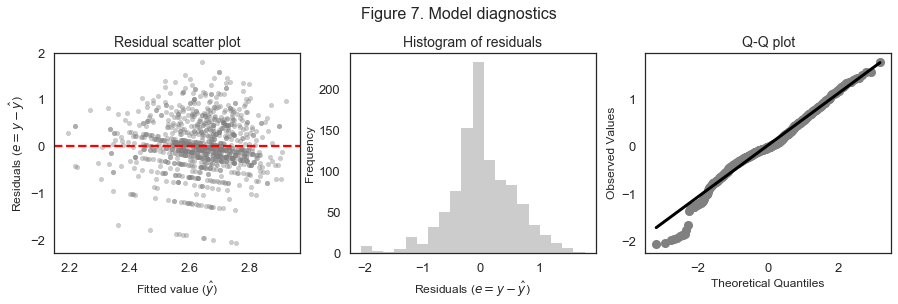

In [12]:
# Calculate errors
pred = res.fittedvalues
errors = y_train - pred

sample = np.random.randint(len(pred), size=1000)
pred = pred[sample]
errors = errors[sample]

# Residual plots
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].scatter(pred, errors, color='grey', alpha=0.4, s=20)
ax[0].axhline(y=0, color='red', label='zero error', linestyle='dashed')
ax[0].set_title('Residual scatter plot', fontsize=14)
ax[0].set_xlabel('Fitted value ($\hat{y}$)', fontsize=12)
ax[0].set_ylabel('Residuals ($e = y - \hat{y}$)', fontsize=12);

ax[1].hist(errors, color='grey', bins=20, alpha=0.4);
ax[1].set_title('Histogram of residuals', fontsize=14)
ax[1].set_xlabel('Residuals ($e = y - \hat{y}$)', fontsize=12)
ax[1].set_ylabel('Frequency', fontsize=12);

stats.probplot(errors, plot=ax[2]);
ax[2].get_lines()[0].set_markerfacecolor('grey')
ax[2].get_lines()[1].set_color('black')
ax[2].get_lines()[1].set_linewidth(3)
ax[2].set_title('Q-Q plot', fontsize=14);
ax[2].set_xlabel('Theoretical Quantiles', fontsize=12)
ax[2].set_ylabel('Observed Values', fontsize=12);

plt.suptitle("Figure 7. Model diagnostics", fontsize=16);
plt.subplots_adjust(top=0.82);

plt.savefig("output/modelC_diagnostics.png", bbox_inches='tight')

The normality of residuals assumption is still a concern, although the distribution does appear slightly more normal compared to the previous models. The systematic clustering of residuals in the residual plot has also reduced slightly, due to the larger number of predictors included in the model.

### Feature selection with Lasso regression

Given the concerns with the distribution of the residuals and therefore also with the confidence intervals of the parameter estimates, the next section determines emperical confidence intervals for the model parameters using a resampling approach. This involves fitting a large number of regression models based on resampled datasets, created by sampling from the original dataset with replacement. A Lasso regularized linear regression model, that includes a penalty factor in the loss function based on the sum of the absolute value of the coefficients included in the model, is fit at each step. Insignificant coefficients in the Lasso regression model will often be shrunk to zero, providing a more parsimonious model. By repeating this process many times and recording the model coefficients at each step an emperical distribution of each of the model coefficients is obtained.

In [13]:
#
# Data prep for Lasso
#

# List of standard predictors in dataset
first_index = data.columns.get_loc("review_count")
last_index = data.columns.get_loc("first_inspection")
model_cols = list(data.columns[first_index: last_index + 1])

# Exclude violation vars
model_cols = [c for c in model_cols if "violation" not in c]

# Add transformed predictors
transformed_vars = ['log_review_count', 'sqrt_score_avg', 'sqrt_score_prev']
for c in transformed_vars:
    model_cols.append(c)
    
# Drop untransformed / collinear predictors
exclude_vars = ['review_count', 'score_avg', 'score_prev']
for c in exclude_vars:
    model_cols.remove(c)

# Response
model_cols.append('log_score')

# Create train and test sets
train_df, test_df = train_test_split(data[model_cols], test_size=0.5, random_state=87)

# Model predictors
X_train = train_df.iloc[:,:-1].values
X_test = test_df.iloc[:,:-1].values

# Scale predictors
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Response
y_train = train_df.iloc[:,-1].values
y_test = test_df.iloc[:,-1].values

In [14]:
#
# Fit initial Lasso model
#

# Fit model
mod = LassoCV(cv=5, max_iter=10000)
mod.fit(X_train, y_train)

# Non-zero coefficients
coefficients = pd.DataFrame(mod.coef_, columns=["coef"], index=model_cols[:-1])

In [15]:
#
# Fit multiple Lasso models with bootstrapping to create empirical confidence interval for parameters
#

n, p = X_train.shape
coef = np.zeros((nsims, p))

for i in range(nsims):
    
    sample = np.random.randint(0, n, n)
    X_train_boot = X_train[sample]
    y_train_boot = y_train[sample]
    
    # Fit model
    mod = LassoCV(cv=5, max_iter=100000)
    mod.fit(X_train_boot, y_train_boot)
    
    # Get coefficients
    coef[i,:] = mod.coef_

In [16]:
alpha = 0.025
coef_boot = pd.DataFrame(coef)

# Get empirical lower and upper bounds
LB = coef_boot.quantile(alpha)
UB = coef_boot.quantile(1-alpha)
C = np.logical_and(LB <= np.zeros(p), np.zeros(p) <= UB)

# Get mean estimate
coef_mean = coef_boot.mean().to_frame()
coef_mean['LB'] = LB
coef_mean['UB'] = UB

coef_mean['name'] = model_cols[:-1]
coef_mean = coef_mean.loc[np.logical_not(C),:]

# Format
coef_mean.columns = ['coef', 'LB', 'UB', 'name']
coef_mean.index = coef_mean['name']
coef_mean.drop('name', axis=1, inplace=True)
display(coef_mean)

,coef,LB,UB
name,,,
rating,-0.028477,-0.044010,-0.013297
cat_latin,0.014891,0.001479,0.028004
cat_indpak,0.014257,0.001397,0.028148
cat_newamerican,0.014153,0.000888,0.026717
cat_delis,0.013855,0.002131,0.024545
cat_korean,0.013657,0.002829,0.024171
restaurant_name_chain,-0.049006,-0.068539,-0.031184
score_std,-0.031288,-0.056100,-0.010020
time_since_prev,-0.014039,-0.025831,-0.001361


The table above provides the mean coefficient values and the bounds for a 95% confidence interval for all the variables in the model that appear to be significantly different from zero based on the constructed confidence intervals. The confidence intervals were constructed by running `500` iterations of the resampling approach described above. 

We note that the restaurant category variables (Latin, Mexican, New American and Deli's) are consistent with those identified as significant in the OLS model in the previous section. 

The histogram and quantile plots below describes the distribution for each of the significant variables identified. Based on the histogram plots most of the variables appear to be normally distributed. However, inspection of the quantile plots shows that the parameter distributions suffers from the same skew observed in the response variable. It is therefore appropriate to use the resampled confidence intervals to evaluate the significance of the paramters, rather than assuming normality.

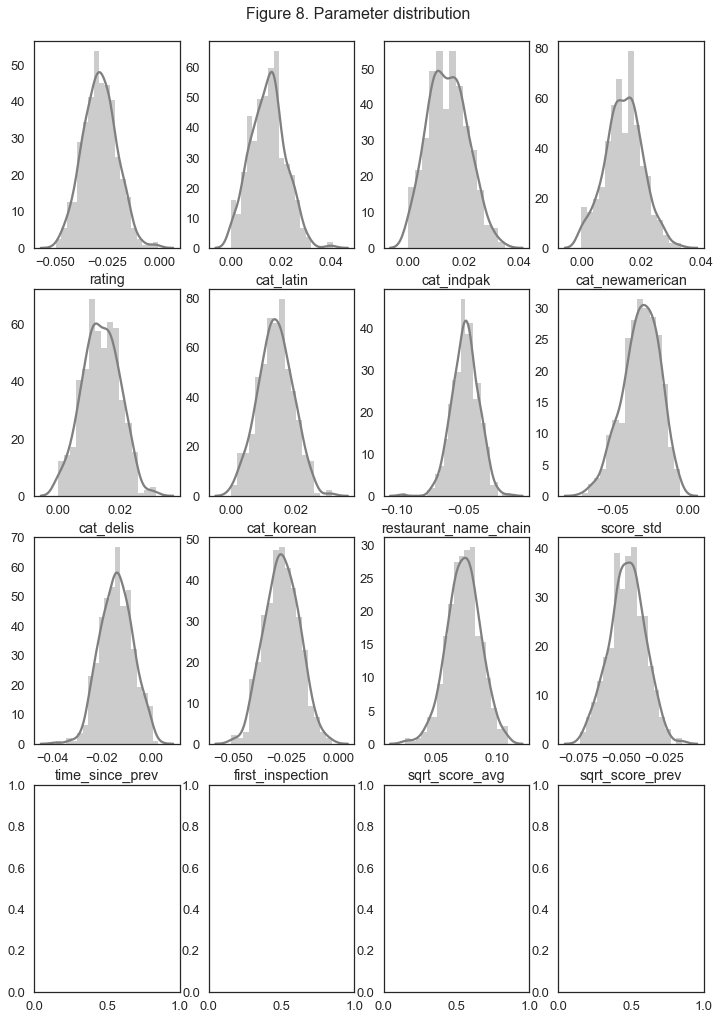

In [17]:
# Plot parameter distributions for significant parameters to assess normality

fig, ax = plt.subplots(4, 4, figsize=(12, 16))
ax = ax.ravel()

cols = list(coef_mean.index)
for c in cols:
    idx = model_cols.index(c)
    coefs = coef_boot.loc[:,idx]
    sns.distplot(coefs, color='grey', ax = ax[cols.index(c)])
    ax[cols.index(c)].set_xlabel(c);
    
plt.suptitle("Figure 8. Parameter distribution", fontsize=16);
plt.subplots_adjust(top=0.95);
    
plt.savefig("output/parameter_distributions_hist.png", bbox_inches='tight')

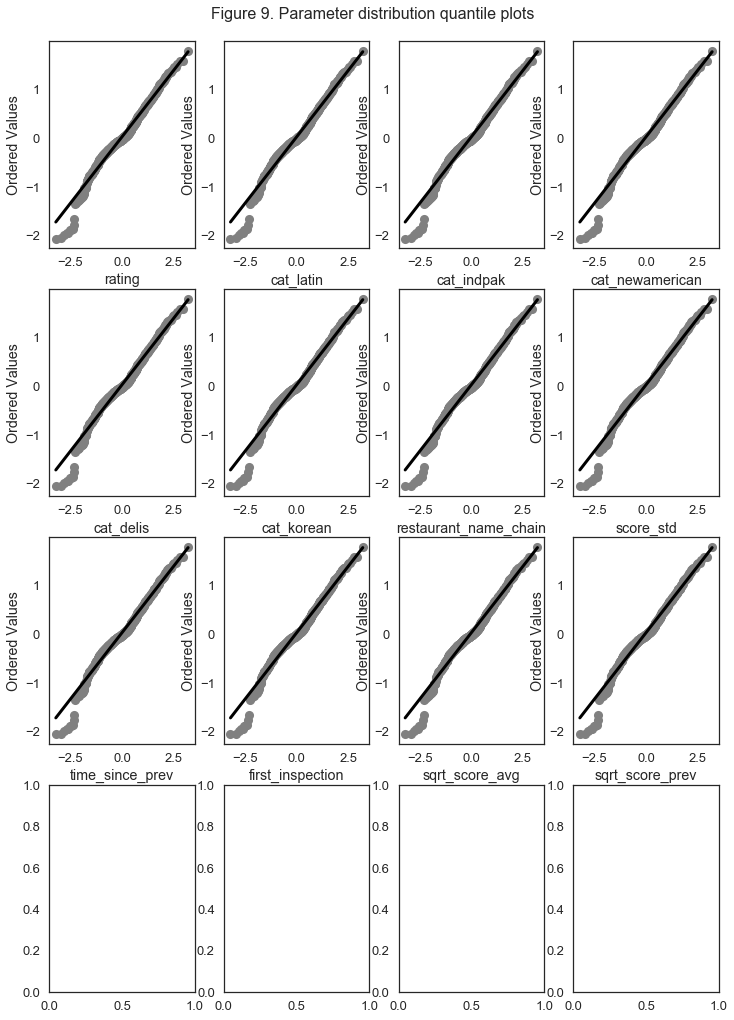

In [18]:
# Plot quantile plots for significant parameters to assess normality

fig, ax = plt.subplots(4, 4, figsize=(12, 16))
ax = ax.ravel()

cols = list(coef_mean.index)
for c in cols:
    idx = model_cols.index(c)
    coefs = coef_boot.loc[:,idx]
    i = cols.index(c)
    stats.probplot(errors, plot=ax[i]);
    ax[i].get_lines()[0].set_markerfacecolor('grey')
    ax[i].get_lines()[1].set_color('black')
    ax[i].get_lines()[1].set_linewidth(3)
    ax[i].set_title('')
    ax[i].set_xlabel(c);
    
plt.suptitle("Figure 9. Parameter distribution quantile plots", fontsize=16);
plt.subplots_adjust(top=0.95);
    
plt.savefig("output/parameter_distributions_qqplots.png", bbox_inches='tight')

### Updated OLS model with selected features

Finally we update the OLS model to only include the significant variables from the feature selection process.

In [19]:
# Get subset predictors
model_cols = list(coef_mean.index)

# Response
model_cols.append('log_score')

# Create train and test sets
train_df, test_df = train_test_split(data[model_cols], test_size=0.5, random_state=87)

# Model predictors
X_train = train_df.iloc[:,:-1].values
X_test = test_df.iloc[:,:-1].values

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Response
y_train = train_df.iloc[:,-1].values
y_test = test_df.iloc[:,-1].values

# Fit model
mod = OLS(y_train, X_train)
res = mod.fit()

# Print summary statistics
names = ['const'] + list(train_df.columns[:-1])
display(res.summary(xname=names))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     31.81
Date:                Mon, 16 Jul 2018   Prob (F-statistic):           2.31e-72
Time:                        18:02:29   Log-Likelihood:                -6147.6
No. Observations:                7625   AIC:                         1.232e+04
Df Residuals:                    7612   BIC:                         1.241e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.6394      0.053     50.244      0.000       2.536       2.742
rating                   -0.0592      0.010     -5.928      0.000      -0.079      -0.040
cat_latin                 0.1149      0.039      2.911      0.004       0.038       0.192
cat_indpak                0.1158      0.040      2.924      0.003       0.038       0.193
cat_newamerican           0.0778      0.027      2.839      0.005       0.024       0.131
cat_delis                 0.1106      0.042      2.628      0.009       0.028       0.193
cat_korean                0.1473      0.049      2.988      0.003       0.051       0.244
restaurant_name_chain    -0.2190      0.025     -8.782      0.000      -0.268      -0.170
score_std                -0.0066      0.001     -4.457      0.000      -0.009      -0.004
time_since_prev          -0.0610      0.017     -3.678      0.000      -0.094      -0.029
first_inspection         -0.1347      0.024     -5.547      0.000      -0.182      -0.087
sqrt_score_avg            0.1328      0.012     11.394      0.000       0.110       0.156
sqrt_score_prev          -0.0522      0.007     -7.364      0.000      -0.066      -0.038
==============================================================================
Omnibus:                      272.245   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              591.168
Skew:                          -0.226   Prob(JB):                    4.26e-129
Kurtosis:                       4.287   Cond. No.                         99.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

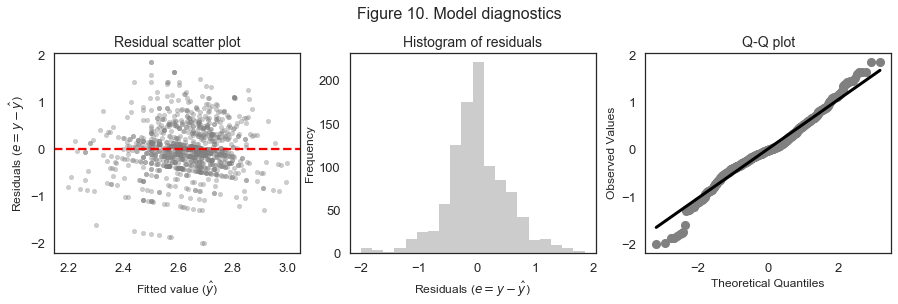

In [20]:
# 
# Test data diagnostics
#

# Calculate errors
pred = res.predict(X_test)
errors = y_test - pred

sample = np.random.randint(len(pred), size=1000)
pred = pred[sample]
errors = errors[sample]

# Predicted vs observed data
df = pd.DataFrame(y_test[sample])
df['pred'] = pred
df.columns = ['observed', 'pred']

# Residual plots
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].scatter(pred, errors, color='grey', alpha=0.4, s=20)
ax[0].axhline(y=0, color='red', label='zero error', linestyle='dashed')
ax[0].set_title('Residual scatter plot', fontsize=14)
ax[0].set_xlabel('Fitted value ($\hat{y}$)', fontsize=12)
ax[0].set_ylabel('Residuals ($e = y - \hat{y}$)', fontsize=12);

ax[1].hist(errors, color='grey', bins=20, alpha=0.4);
ax[1].set_title('Histogram of residuals', fontsize=14)
ax[1].set_xlabel('Residuals ($e = y - \hat{y}$)', fontsize=12)
ax[1].set_ylabel('Frequency', fontsize=12);

stats.probplot(errors, plot=ax[2]);
ax[2].get_lines()[0].set_markerfacecolor('grey')
ax[2].get_lines()[1].set_color('black')
ax[2].get_lines()[1].set_linewidth(3)
ax[2].set_title('Q-Q plot', fontsize=14);
ax[2].set_xlabel('Theoretical Quantiles', fontsize=12)
ax[2].set_ylabel('Observed Values', fontsize=12);

plt.suptitle("Figure 10. Model diagnostics", fontsize=16);
plt.subplots_adjust(top=0.82);

plt.savefig("output/modelD_diagnostics_test.png", bbox_inches='tight')

## Logistic Regression

In the next section we consider a different question using Logistic Regression. Rather than modeling the inspection score, we investigate whether the Yelp review rating can be predicted using the inspection data, including specific violation codes recorded for each inspection that were not considered in the previous analysis.

The Yelp review ratings have discrete values between 1 and 5, with 1 being a poor review and 5 being great. We are principally interested in understanding if there is an association between inspection scores and whether a restaurant has a very poor average Yelp rating. We therefore consider a binary class based on the Yelp ratings, with ratings below 3 deemed to be poor and ratings of 3 and higher deemed to be average or good. The charts below show the number of observations for both the raw rating and the binary class based on the ratings.

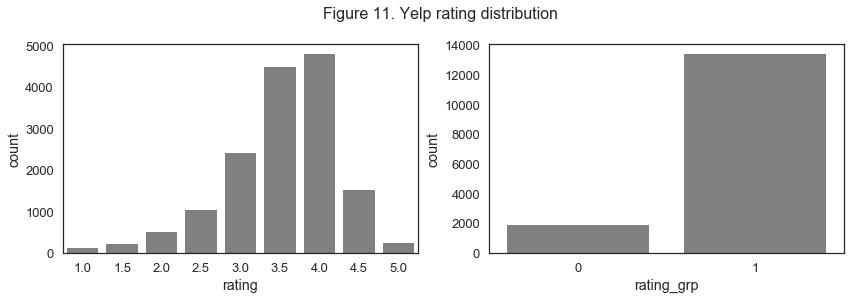

In [21]:
#
# Data prep
#

def rating_group(row):
    if row < 3:
        label = 0
    else:
        label = 1
    return label

# Creating 'rating group' response
data['rating_grp'] = data['rating'].apply(rating_group)

# Plot number of observations in each group
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

sns.countplot(data['rating'], color='grey', ax=ax[0]);
sns.countplot(data['rating_grp'], color='grey', ax=ax[1]);

plt.suptitle("Figure 11. Yelp rating distribution", fontsize=16);
plt.subplots_adjust(top=0.85);

plt.savefig("output/classification_classes.png", bbox_inches='tight')

In [22]:
# Data prep

col = 'grade'
data[col].fillna('missing', inplace=True)
df = pd.get_dummies(data[col], prefix=col)
data = data.join(df)
data.drop(col, axis=1, inplace=True)

In [23]:
# Selected predictors + response
model_cols = ['log_review_count', 'price', 'log_score', 'sqrt_score_avg', 'rating_grp']

# Create train and test sets
train_df, test_df = train_test_split(data[model_cols], test_size=0.5, random_state=87)

# Model predictors
X_train = train_df.iloc[:,:-1].values
X_test = test_df.iloc[:,:-1].values

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Response
y_train = train_df.iloc[:,-1].values
y_test = test_df.iloc[:,-1].values

# Fit model
clf = LogisticRegressionCV(Cs=10, cv=10, n_jobs=4, verbose=0)
clf.fit(X_train, y_train)

# Train accuracy
acc = clf.score(X_train, y_train)

### Predicting Yelp rating using inspection scores

We again use Lasso regression for feature selection to identify the most significant predictors. This provides a more parsimonious model with reduced multi-collinearity, making it easier to interpret the model results. The table below shows the variables coefficients that are significantly different from zero at the 5% significance level based on the bootstrap confidence intervals.

We make the following observations based on the mean coefficicient for each predictor:
* Restaurants with a larger number of Yelp reviews (`log_review_count`) are less likely to have a poor rating (less than 3).
* Restaurants that have been identified as chains (`restaurant_name_chain`) are more likely to have a poor rating 
* Wine bars, pubs and Italian restaurants have relatively better ratings compared to Chinese and "Chicken Wing" restaurants
* Violation code 4D (food worker not washing hands after using toilet, coughing or sneezing) also appears to have an association with the average Yelp rating, with restaurants being more likely to have a poor rating if this violation code has been recorded

In [24]:
#
# Data prep
#

# All possible predictors
first_index = data.columns.get_loc("review_count")
last_index = data.columns.get_loc("grade_missing")
model_cols = list(data.columns[first_index: last_index + 1])

# Exclude perfectly collinear predictors 
exclude_vars = ['rating', 'rating_grp', 'review_count', 'score', 'log_score']
for c in exclude_vars:
    model_cols.remove(c)

# Response
model_cols.append('rating_grp')

# Create train and test sets
train_df, test_df = train_test_split(data[model_cols], test_size=0.5, random_state=87)

# Model predictors
X_train = train_df.iloc[:,:-1].values
X_test = test_df.iloc[:,:-1].values

# Scale predictors
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Response
y_train = train_df.iloc[:,-1].values
y_test = test_df.iloc[:,-1].values

In [25]:
# Fit model
n, p = X_train.shape
coef = np.empty((nsims, p))

for i in range(nsims):
    
    # Bootstrap 
    sample = np.random.randint(0, n, n)
    X_train_boot = X_train[sample]
    y_train_boot = y_train[sample]    
    
    # Fit model
    clf = LogisticRegression(C=0.05, penalty='l1', solver='liblinear', verbose=0, max_iter=100)
    clf.fit(X_train_boot, y_train_boot);
    
    # Coefficients
    coef[i,:] = clf.coef_

In [26]:
alpha = 0.025
coef_boot = pd.DataFrame(coef)

# Get empirical lower and upper bounds
LB = coef_boot.quantile(alpha)
UB = coef_boot.quantile(1-alpha)

C = np.logical_and(LB <= np.zeros(p), np.zeros(p) <= UB)
#print("Number of significant coefficients:", str(np.sum(1 - C)))

# Get mean estimate
coef_mean = coef_boot.mean().to_frame()
coef_mean['LB'] = LB
coef_mean['UB'] = UB

coef_mean['name'] = model_cols[:-1]
coef_mean = coef_mean.loc[np.logical_not(C),:]

# Format
coef_mean.columns = ['coef', 'LB', 'UB', 'name']
coef_mean.index = coef_mean['name']
coef_mean.drop('name', axis=1, inplace=True)
display(coef_mean.round(4))

,coef,LB,UB
name,,,
trans_restaurant_reservation,0.2611,0.1402,0.3811
cat_tradamerican,-0.1280,-0.1983,-0.0535
cat_vegetarian,0.1008,0.0170,0.1708
cat_bars,0.1000,0.0107,0.2094
cat_chinese,-0.1383,-0.2122,-0.0719
cat_chicken_wings,-0.2040,-0.2677,-0.1408
cat_bakeries,0.0852,0.0003,0.1784
cat_bubbletea,0.1549,0.1113,0.1913
cat_mideastern,0.0674,0.0024,0.1447


In [27]:
# Re-fit model

# Predictors 
model_cols = list(coef_mean.index)

# Response
model_cols.append('rating_grp')

# Create train and test sets
train_df, test_df = train_test_split(data[model_cols], test_size=0.5, random_state=87)

# Model predictors
X_train = train_df.iloc[:,:-1].values
X_test = test_df.iloc[:,:-1].values

# Scale predictors
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Response
y_train = train_df.iloc[:,-1].values
y_test = test_df.iloc[:,-1].values

clf = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', verbose=0, max_iter=100)
clf.fit(X_train, y_train);

The Receiver Operating Characteristic (ROC) curve provides an indication of the accuracy of the classification model. It shows the relationship between the True Positive Rate (proportion of `class 1` restaurants identified correctly) and the False Positive Rate (proportion of `class 0` restuarants predicted to be `class 1`). A perfect model has a True Positive Rate (TPR) of 1 and a False Positive Rate (FPR) of 0. The area under the curve (AUC) is a measure of predictive performance. 

From the ROC chart below, created using on a 50% test dataset, we note that the Logistic Regression model is reasonably effective at identifying restaurants with a poor rating (`class 0`) based on the inspection data and other attributes of the restaurant. The model correctly classifies 90% of observations included in the test dataset.

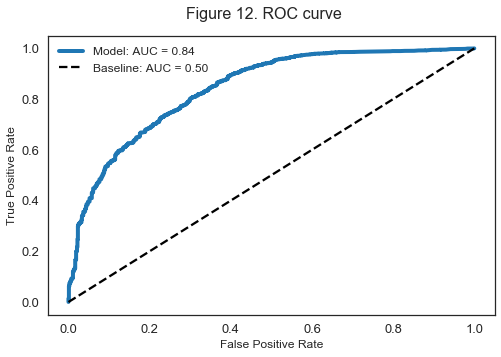

In [28]:
# ROC plot

probs_test = clf.predict_proba(X_test)[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs_test, pos_label=1)
fpr_0, tpr_0, threshold_0 = roc_curve(y_test, np.ones(len(y_test)), pos_label=1)

auc = roc_auc_score(y_test, probs_test)
auc0 = roc_auc_score(y_test, np.ones(len(y_test)))

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.plot(fpr, tpr, label = 'Model: AUC = %0.2f' % auc, linewidth=4)
plt.plot(fpr_0, tpr_0, 'k--', label = 'Baseline: AUC = %0.2f' % auc0)

#plt.title('Receiver Operating Characteristic', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.legend(fontsize=12);

plt.suptitle("Figure 12. ROC curve", fontsize=16);
plt.subplots_adjust(top=0.90);

plt.savefig("output/modelE_ROC.png", bbox_inches='tight')

In [29]:
test_accuracy = clf.score(X_test, y_test)